# Equivalent dose and biologically effective dose

In the linear-quadratic model ([https://doi.org/10.1016/0360-3016(82)90459-X](https://doi.org/10.1016/0360-3016(82)90459-X)), a biological effect, `E`, on tissue receiving a total physical radiation dose, `D`, delivered in `n` equal, well-separated, short-duration, fractions, each of size `d0`, is quantified in terms of parameters `alpha`, `beta` that depend on tissue type and effect considered ([https://doi.org/10.1259/0007-1285-62-740-679](https://doi.org/10.1259/0007-1285-62-740-679)):

```
E = alpha * n * d0 + beta * n * d0**2
  = alpha * D + beta * D * d0.
```

The total equivalent dose, `EQDd`, for fractions of size `d` is such that:

```
E = alpha * EQDd + beta * EQDd * d = alpha * D + beta * D * d0.
```

Rearranging gives ([https://doi.org/10.1016/S0167-8140(83)80021-8](https://doi.org/10.1016/S0167-8140(83)80021-8)):

```
EQDd = D * (d0 + alpha/beta) / (d + alpha/beta).
```

The biologically effective dose, `BED`, is defined to be ([https://doi.org/10.1259/0007-1285-62-740-679](https://doi.org/10.1259/0007-1285-62-740-679)):

```
BED = E / alpha
    = n * d + n * d**2 / (alpha / beta)
    = D + (D**2 / n) / (alpha / beta)
```

and is the total equivalent dose in the limit where `d` tends to zero.

This notebook demonstrates use of scikit-rt to obtain equivalent dose for a specified dose per fraction, and biologically effective dose.  It uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)  
https://doi.org/10.6084/m9.figshare.12579707.v1

**Note:** If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` in the
first code cell below.  The download file has a size of 1.6 GB, so download may
take a while.

## Module import and data download

The following imports modules needed for this example, defines the path
to the data directory, and downloads the example dataset if not already present, and sets some viewer options.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from skrt import Patient, set_viewer_options, ROI, StructureSet
from skrt.core import download
from skrt.dose import sum_doses

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)
    
# Set Matplotlib runtime configuration (optional).
options = set_viewer_options(figsize=(20, 8))

# Indicate whether to show user interface for image viewer.
no_ui = False

## Reading patient data

The following demonstrates creation of a sorted list of paths to patient folders, reading of the data for a single [Patient](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Patient), and identification of the [Study](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Study) containing data of interest here: CT image, structure set, radiotherapy plan, dose.

In [2]:
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))

# Define index for path to patient folder of interest.
idx = 0

# Read patient data.
patient = Patient(paths[idx], unsorted_dicom=True)

# Identify study containing ct_image, ct_structure_set, ct_dose, ct_plan.
# If no study contains all of these data types,
# an exception will be raised.
for study in patient.studies + [None]:
    if all(["ct" in getattr(study, f"{dtype}_types", [])
            for dtype in ["image", "structure_set", "dose", "plan"]]):
        break

if study is None:
    raise RuntimeError("No study found with required data types")

## Obtaining references to CT image, structure set, plan dose

The following demonstrates how to obtain references to relevant data objects.  Printing an object will list the object's attributes, and their values.

In [3]:
# Obtain reference to earliest CT image. 
im = study.ct_images[0]

# Define structure containing, and renaming, ROIs to be considered.
rois = im.structure_sets[0].filtered_copy(
    {"lung_left": "Lung_L1", "lung_right": "Lung_R1", "spinal_cord": "Cord4"},
    keep_renamed_only=True)

# Obtain sum of image-associated doses.
dose = sum_doses(im.doses)

# Ensure that the dose array has the same geometry as the image array.
dose.match_size(im)

# Set the image and plan of the summed doses.
dose.image = im
dose.plan = im.plans[0]

## Calculation of equivalent dose and biologically effective dose

Values of `alpha`/`beta` ratios need to be defined for the ROIs considered.  Values used here are from: [https://doi.org/10.3389/fonc.2019.00674](https://doi.org/10.3389/fonc.2019.00674).

The number of dose fractions may be specified explicitly in the calls to the methods for calculating equivalent dose and biologically effective dose, or otherwise will be taken, if possible, from the radiotherapy plan.

The results of the calcualtions of equivalent dose and biologically effective dose are Dose objects.

In [4]:
# Define alpha / beta ratios.
alpha_beta_ratios = {"lung_left": 3, "lung_right": 3, "spinal_cord": 2}

# Print the maximum dose, and the number of dose fractions.
print(f"Maximum dose: {dose.get_max()} Gy")
print(f"Number of dose fractions: {dose.plan.get_n_fraction()}")

# Calculate eqivalent dose for specified dose per fraction.
# The method get_eqd() is an alias for get_equivalent_dose().
dose_per_fraction = 0.5
eqdn = dose.get_eqd(dose_per_fraction, rois, alpha_beta_ratios)

# Calculate biologically effective dose.
# The method get_bed() is an alias for get_biologically_effective_dose().
bed = dose.get_bed(rois, alpha_beta_ratios)

Maximum dose: 56.56040573120117 Gy
Number of dose fractions: 25


## Dose masking (optional)

For display purposes, the Dose objects are masked here, to show dose information only for the ROIs for which equivalent dose and biologically effective dose have been calculated.

In [5]:
# Mask physical dose.
masked_dose = dose.get_masked_image(rois)

# Mask equivalent dose.
masked_eqdn = eqdn.get_masked_image(rois)

# Mask biologically effective dose.
masked_bed = bed.get_masked_image(rois)

## Display equivalent dose and biologically effective dose

Physical dose, equivalent dose, and biologically effective dose are shown alongside one another, overlain on the CT image, and with ROI contours drawn.

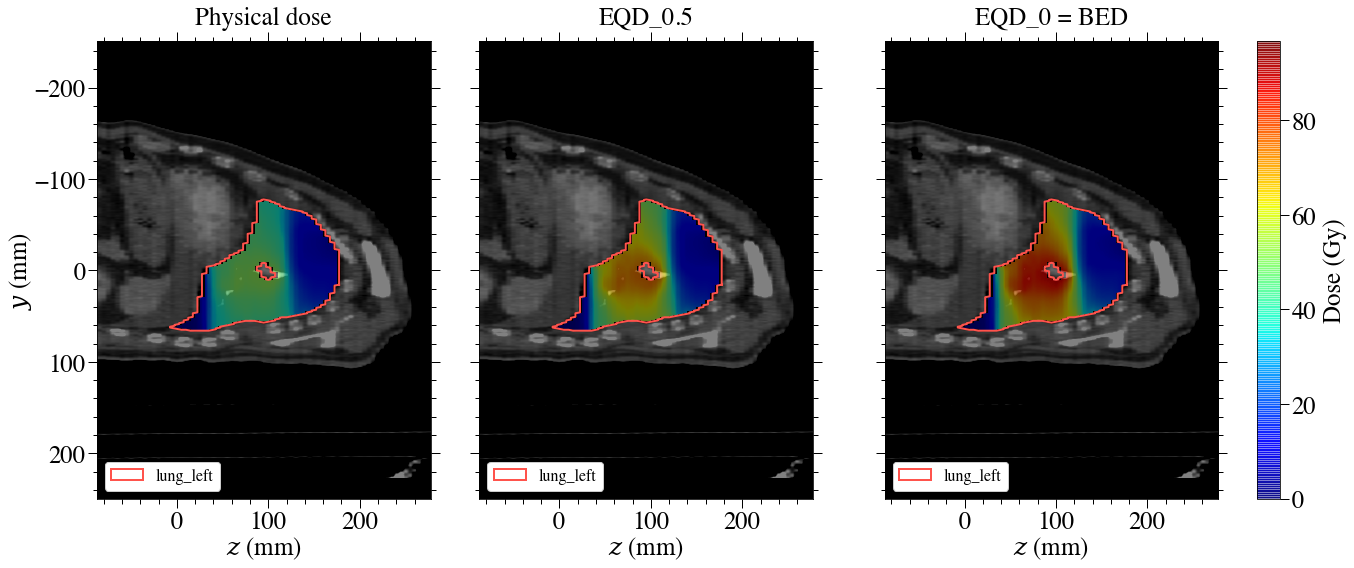

In [6]:
# Display image and doses, with parameters as follows:
#
# images=[im, im] : indicate that the image is to be displayed three times (once as caller).
# dose=[masked_dose, masked_eqdn, masked_bed] : indicate the Dose objects to overlay.
# rois=[rois, rois, rois] : indicate the StructureSet objects to overlay (the same for all images).
# title=["Physical dose", "EQDn", "BED"] : indicate image titles.
# dose_kwargs={"vmax" : bed.get_max()} : indicate keyword arguments to be passed to Matplotlib
#     for dose display.  By default, the maximum intensity value will be taken from the
#     first Dose object displayed.  The maximum intensity is set here to be the (higher) value
#     of the BED Dose object.
# init_view="y-z" : Open viewer showing y-z projection.
# init_roi="lung_left" : Open viewer showing the slice through the centre of the left lung.
# legend=True : Show legend identifying ROIs.
# colorbar=-2 : Show intensity values for dose (but not for image grey scale).
# no_ui=no_ui : Hide or show user interface, depending on whether no_ui is True or False.
# **options : Pass the options dictionary obtained in the call to set_viewer_options().

im.view(images=[im, im],  dose=[masked_dose, masked_eqdn, masked_bed], rois=[rois, rois, rois],
        title=["Physical dose", f"EQD_{dose_per_fraction}", "EQD_0 = BED"],
        dose_kwargs={"vmax": bed.get_max()}, init_view="y-z",
        init_roi="lung_left", legend=True, colorbar=-2, no_ui=no_ui, **options);